,acc-x,acc-y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set
epoch (ms),,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,11
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,11
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,11
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,11
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,11
...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.048000,-1.041500,-0.076500,1.4146,-5.6218,0.2926,E,row,medium,51
2019-01-20 17:33:27.200,-0.037000,-1.030333,-0.053333,-2.7684,-0.5854,2.2440,E,row,medium,51
2019-01-20 17:33:27.400,-0.060000,-1.031000,-0.082000,2.8416,-5.1342,-0.1220,E,row,medium,51


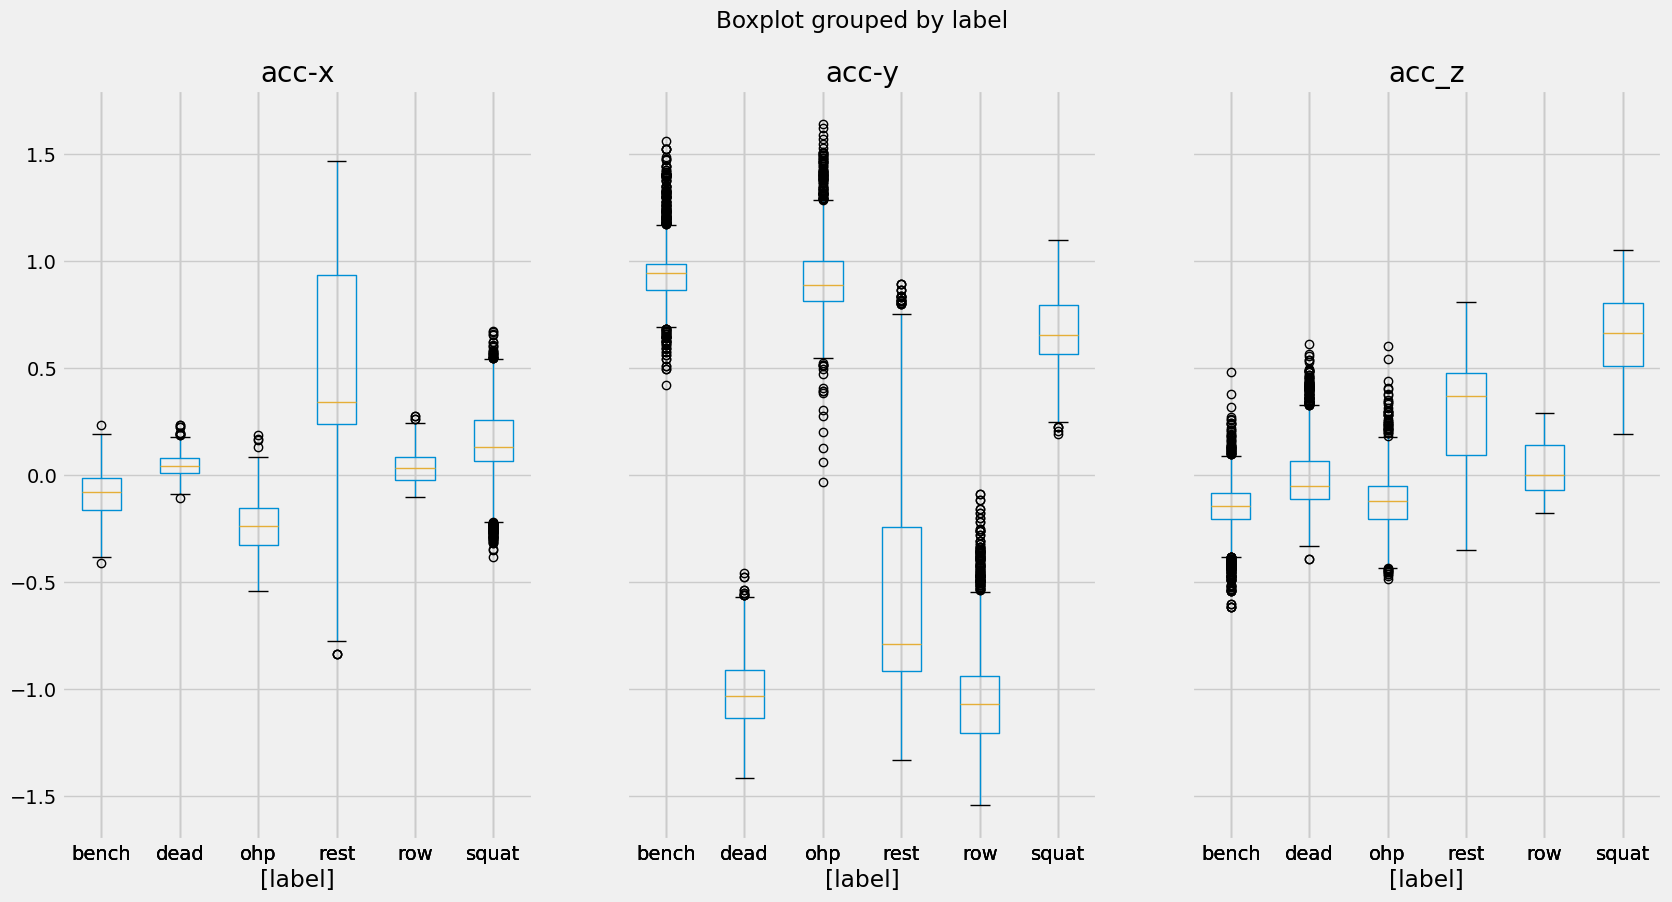

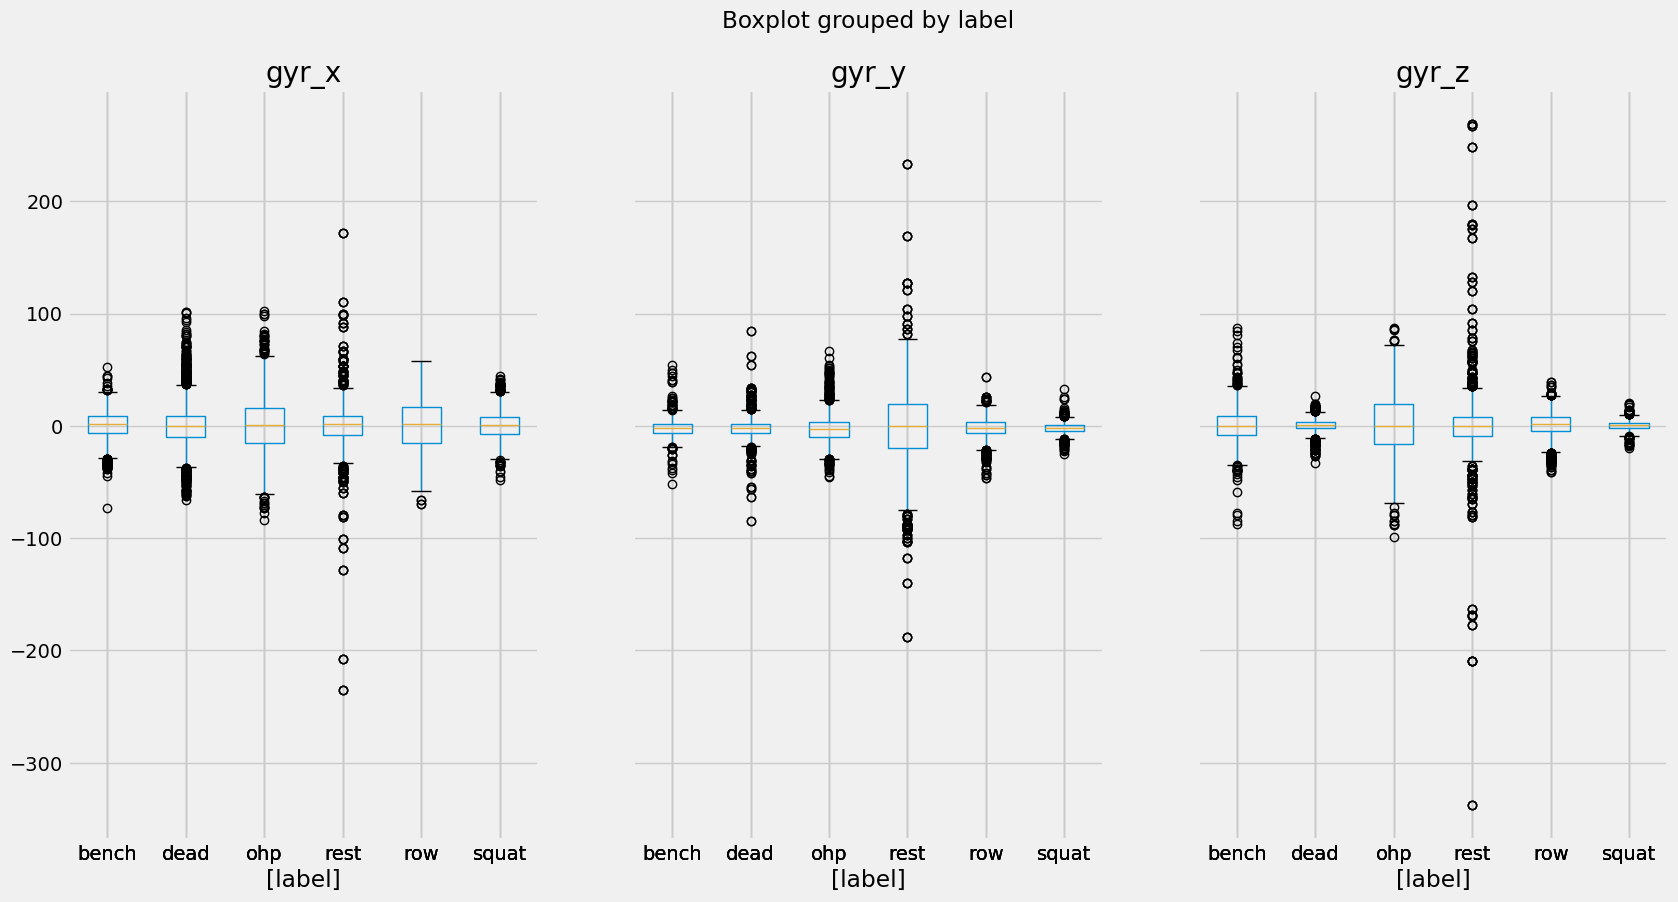

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from sklearn.neighbors import LocalOutlierFactor  # pip install scikit-learn

# --------------------------------------------------------------
# Load data
# --------------------------------------------------------------
df= pd.read_pickle("../../data/interim/done.pkl")
outlier_columns=list(df.columns[:6])
outlier_columns
# --------------------------------------------------------------
# Plotting outliers
# ----------------------
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"]=(20,5)
plt.rcParams["figure.dpi"]=100


# df[["gyr_z","label"]].boxplot(by="label",figsize=(20,10))
df[outlier_columns[:3]+["label"]].boxplot(by="label",figsize=(20,10),layout=(1,3))
df[outlier_columns[3:]+["label"]].boxplot(by="label",figsize=(20,10),layout=(1,3))
df

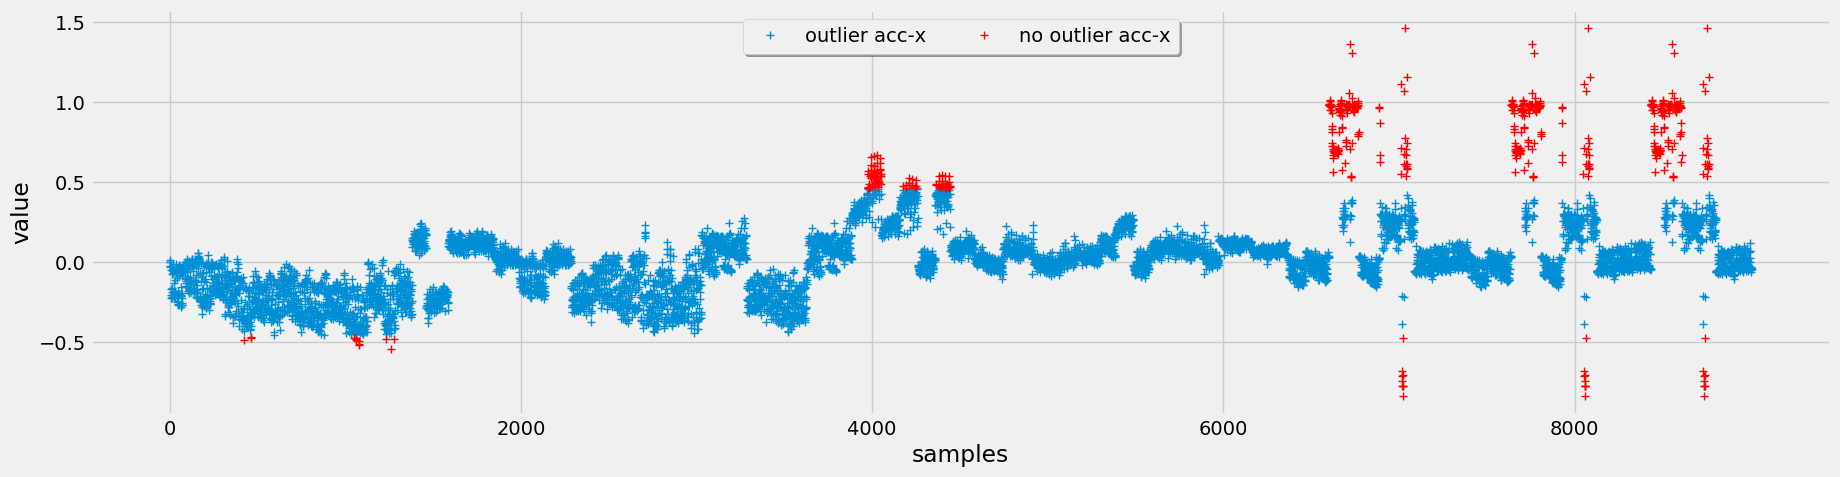

In [46]:
#----------------------------------------
def plot_binary_outliers(dataset, col, outlier_col, reset_index):
    """ Plot outliers in case of a binary outlier score. Here, the col specifies the real data
    column and outlier_col the columns with a binary value (outlier or not).

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): Column that you want to plot
        outlier_col (string): Outlier column marked with true/false
        reset_index (bool): whether to reset the index for plotting
    """

    # Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/util/VisualizeDataset.py

    dataset = dataset.dropna(axis=0, subset=[col, outlier_col])
    dataset[outlier_col] = dataset[outlier_col].astype("bool")

    if reset_index:
        dataset = dataset.reset_index()

    fig, ax = plt.subplots()

    plt.xlabel("samples")
    plt.ylabel("value")

    # Plot non outliers in default color
    ax.plot(
        dataset.index[~dataset[outlier_col]],
        dataset[col][~dataset[outlier_col]],
        "+",
    )
    # Plot data points that are outliers in red
    ax.plot(
        dataset.index[dataset[outlier_col]],
        dataset[col][dataset[outlier_col]],
        "r+",
    )

    plt.legend(
        ["outlier " + col, "no outlier " + col],
        loc="upper center",
        ncol=2,
        fancybox=True,
        shadow=True,
    )
    plt.show()

# --------------------------------------------------------------
# Interquartile range (distribution based)
# --------------------------------------------------------------

# Insert IQR function
def mark_outliers_iqr(dataset, col):
    """Function to mark values as outliers using the IQR method.

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column 
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()

    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    dataset[col + "_outlier"] = (dataset[col] < lower_bound) | (
        dataset[col] > upper_bound
    )

    return dataset

# Plot a single column

col="acc-x"
dataset= mark_outliers_iqr(df,col)
plot_binary_outliers(dataset=dataset,col=col,outlier_col=col+"_outlier",reset_index=True)

In [ ]:
# Local outlier factor (distance based)
# --------------------------------------------------------------

# Insert LOF function

def mark_outliers_lof(dataset, columns, n=20):
    """Mark values as outliers using LOF

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        n (int, optional): n_neighbors. Defaults to 20.
    
    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """
    
    dataset = dataset.copy()

    lof = LocalOutlierFactor(n_neighbors=n)
    data = dataset[columns]
    outliers = lof.fit_predict(data)
    X_scores = lof.negative_outlier_factor_

    dataset["outlier_lof"] = outliers == -1
    return dataset, outliers, X_scores

In [90]:
dataset

,acc-x,acc-y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,outlier_lof
epoch (ms),,,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,11,False
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,11,False
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,11,False
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,11,False
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,11,False
...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.048000,-1.041500,-0.076500,1.4146,-5.6218,0.2926,E,row,medium,51,False
2019-01-20 17:33:27.200,-0.037000,-1.030333,-0.053333,-2.7684,-0.5854,2.2440,E,row,medium,51,False
2019-01-20 17:33:27.400,-0.060000,-1.031000,-0.082000,2.8416,-5.1342,-0.1220,E,row,medium,51,False


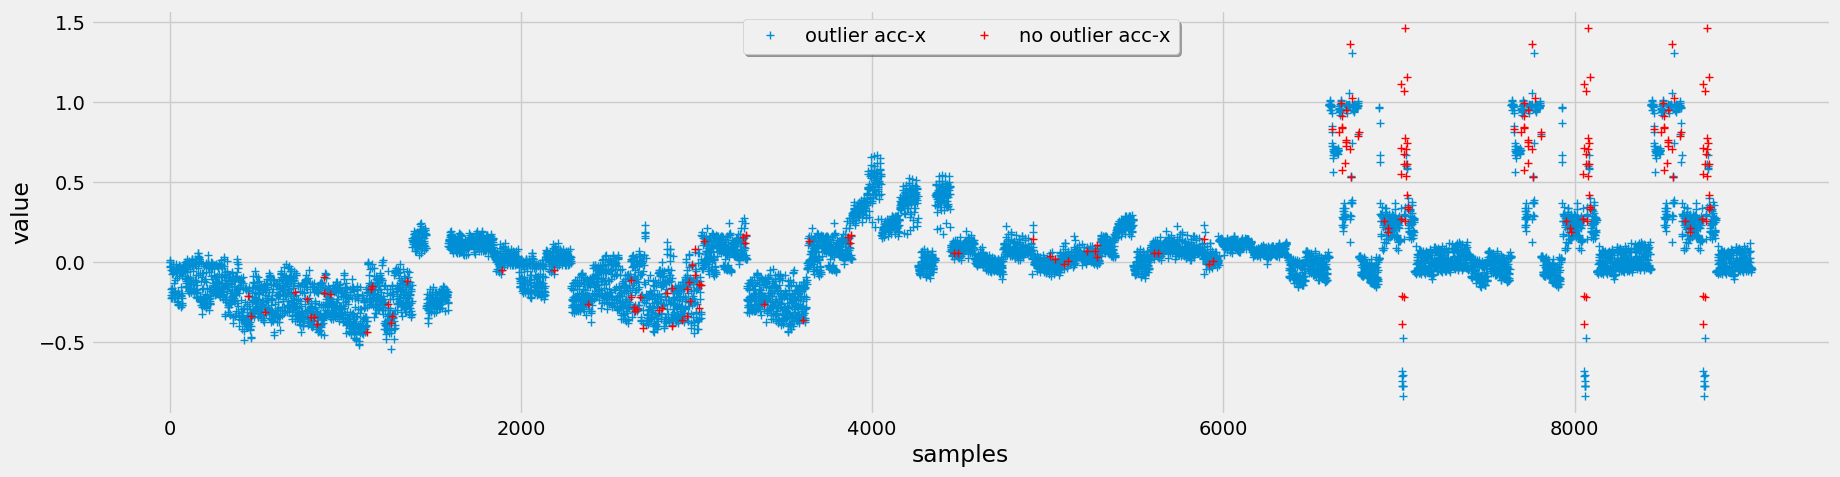

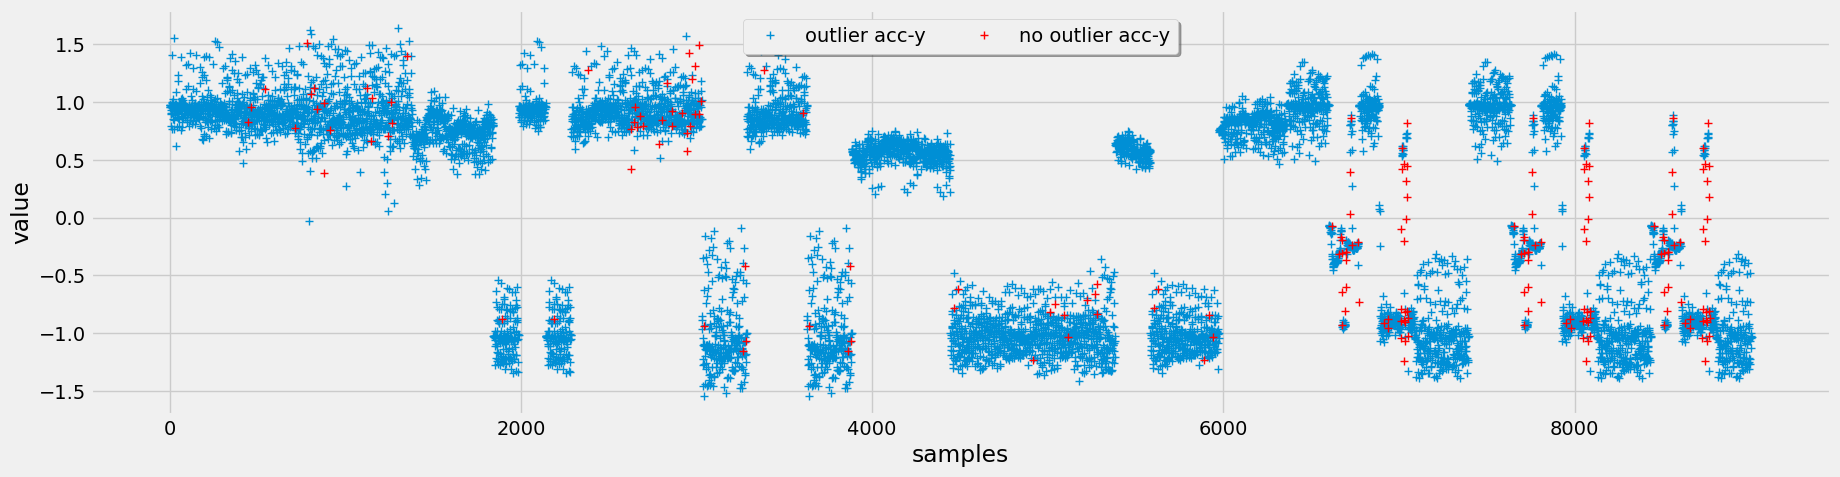

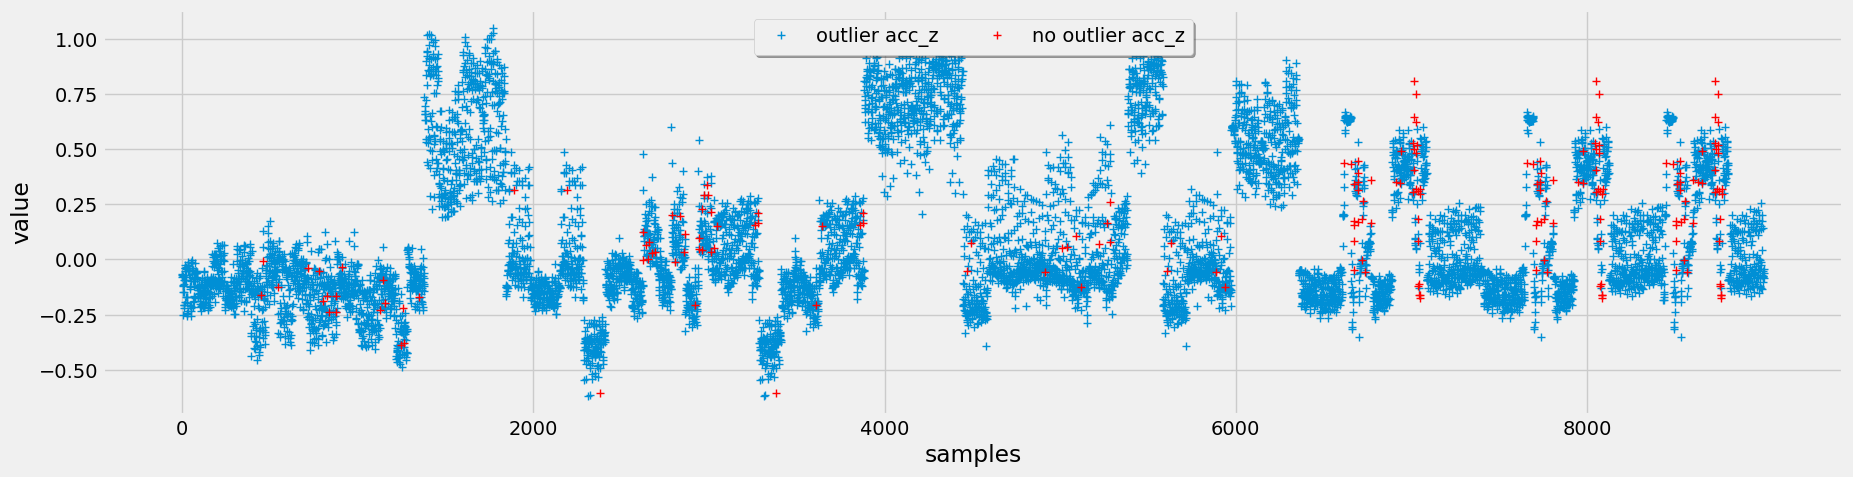

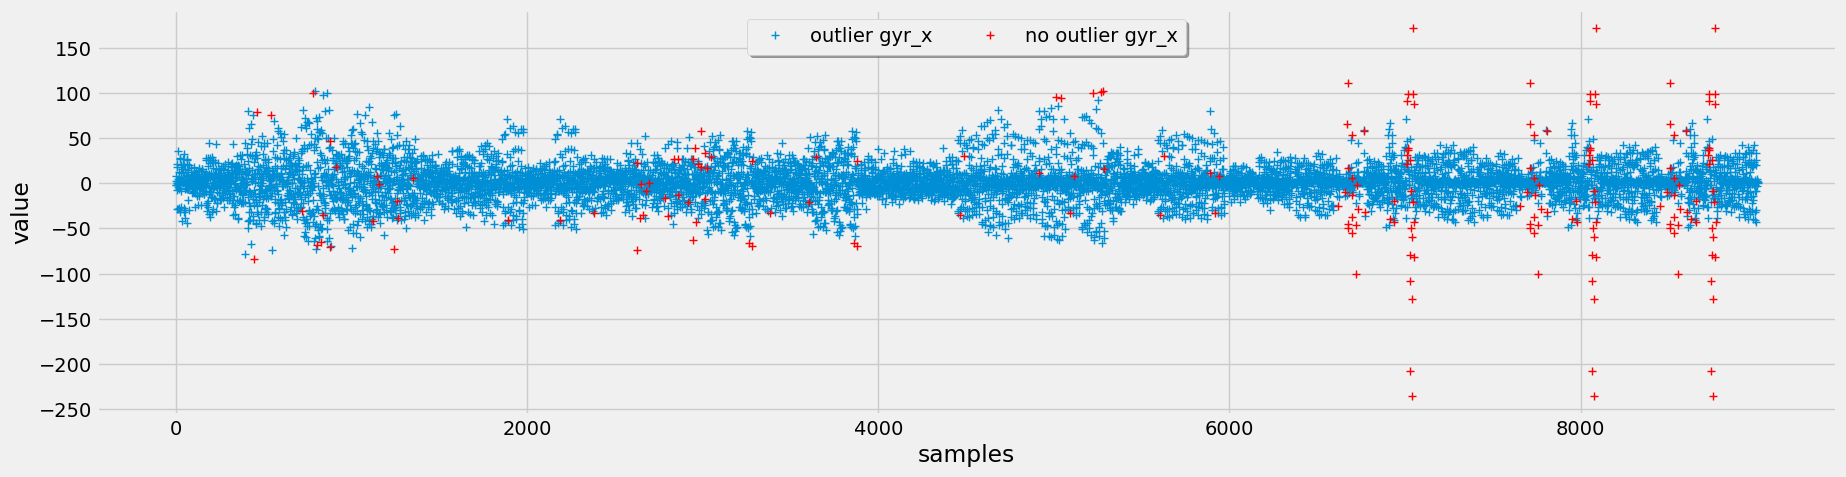

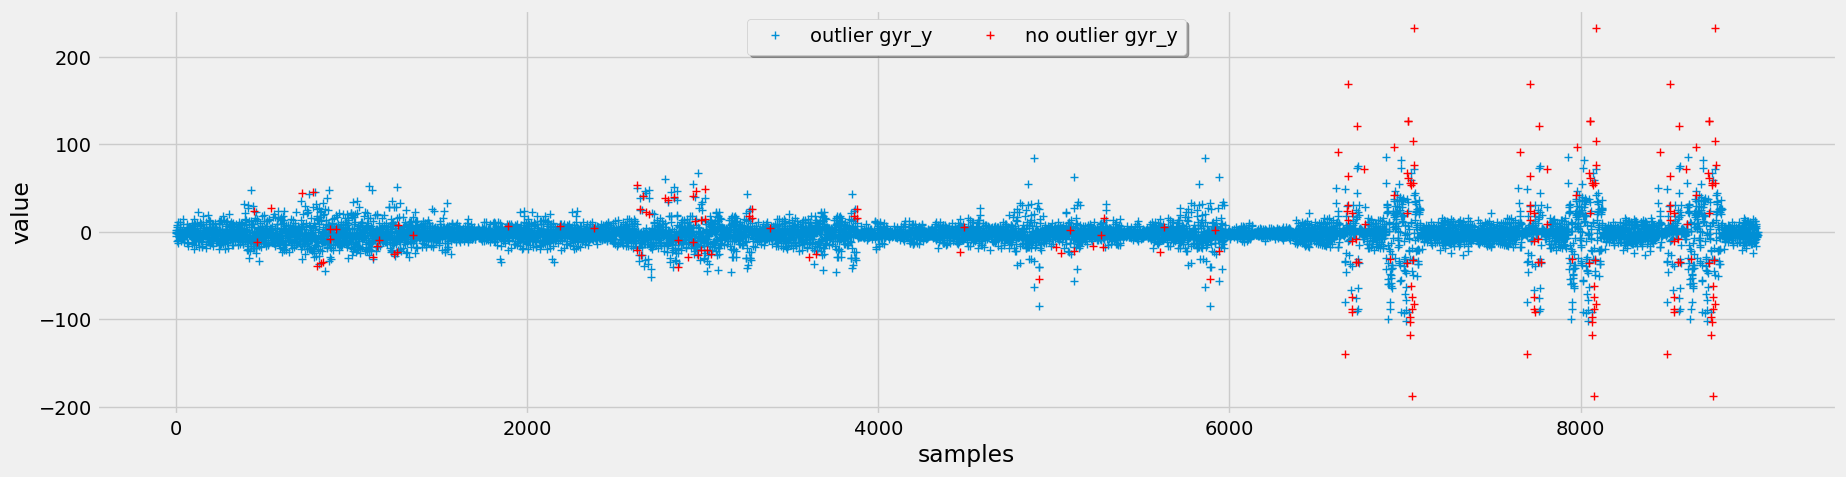

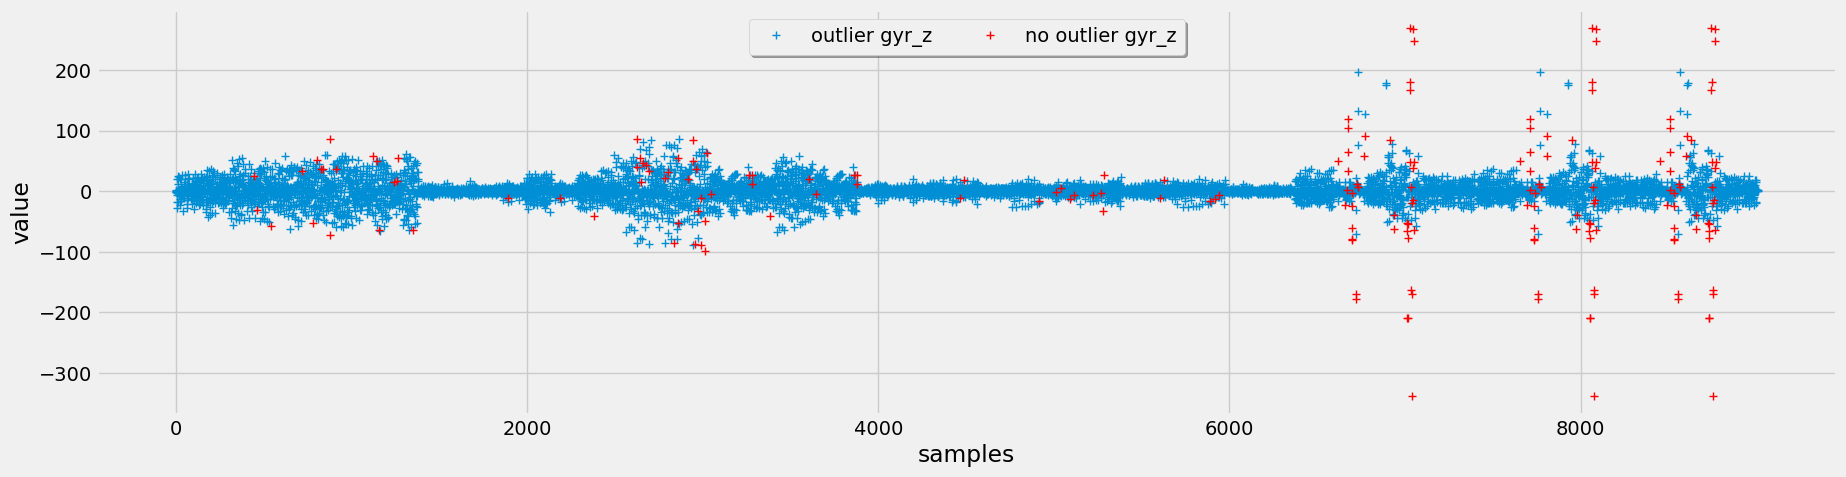

['acc-x', 'acc-y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']

In [128]:
dataset,outliers,X_scores=mark_outliers_lof(df,outlier_columns)
for col in outlier_columns:
    plot_binary_outliers(
        dataset=dataset,col=col,outlier_col="outlier_lof",reset_index=True
        )
# # dataset
outlier_columns
# print(dataset.columns)


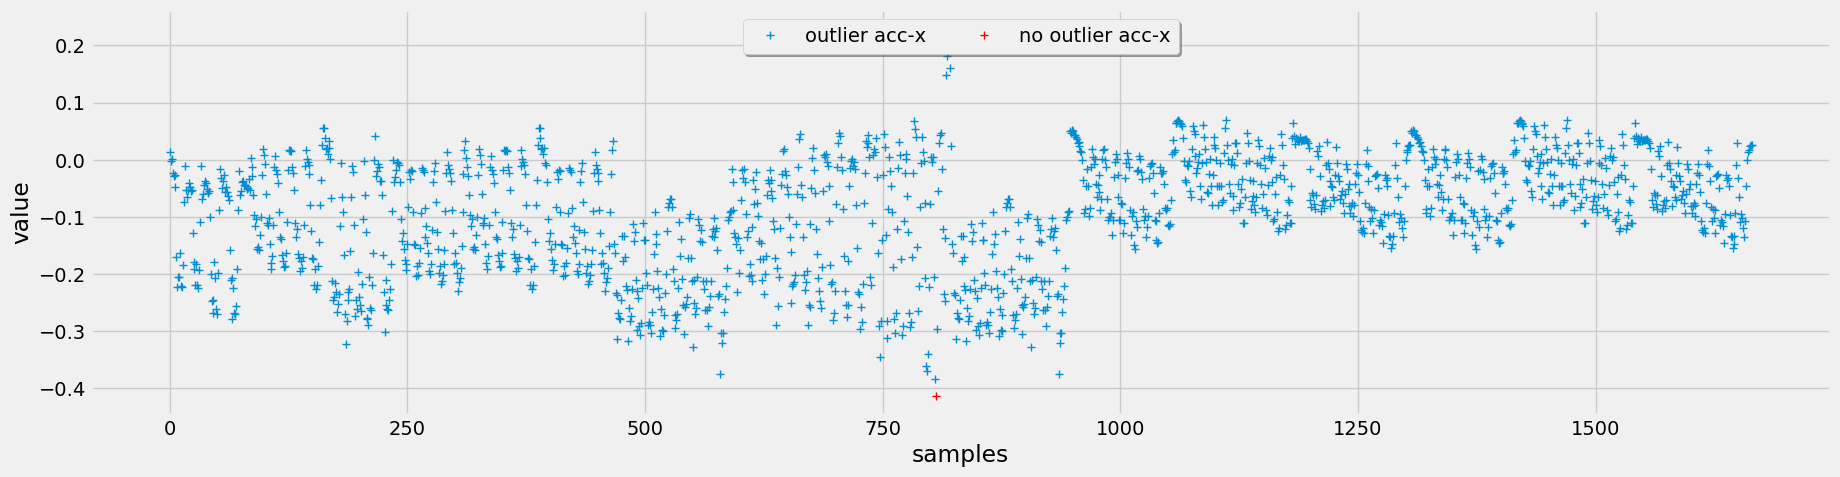

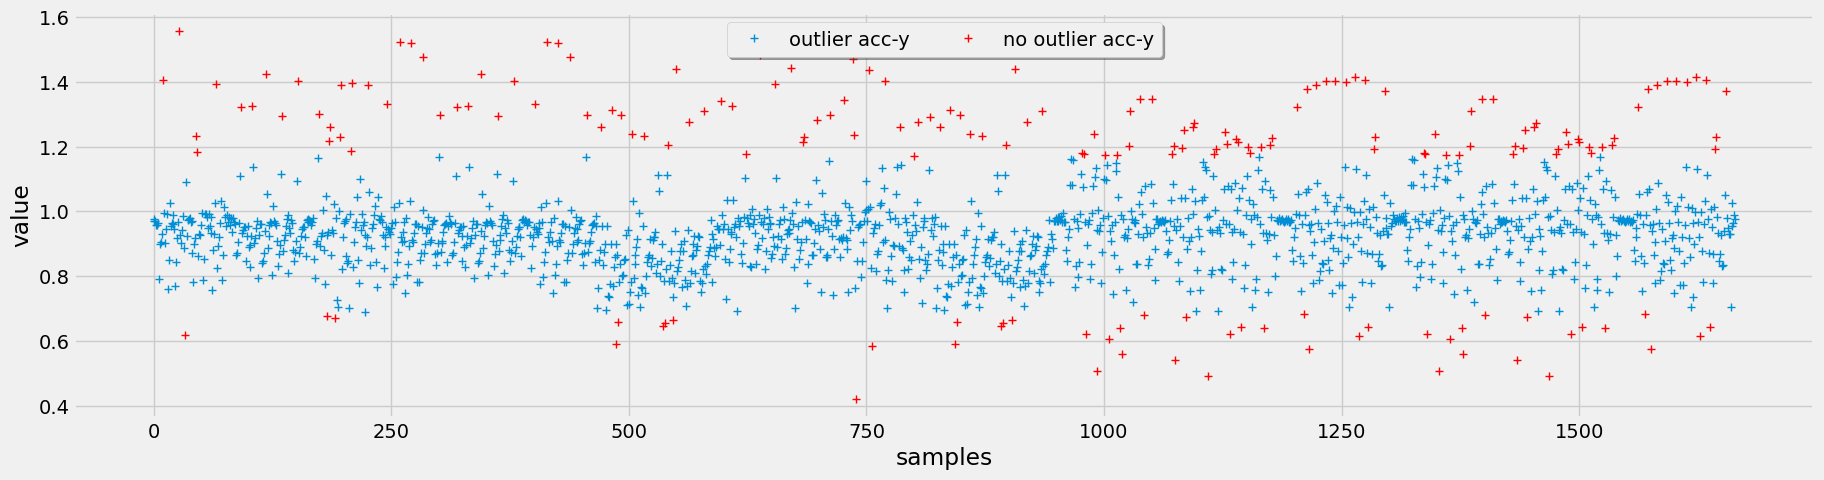

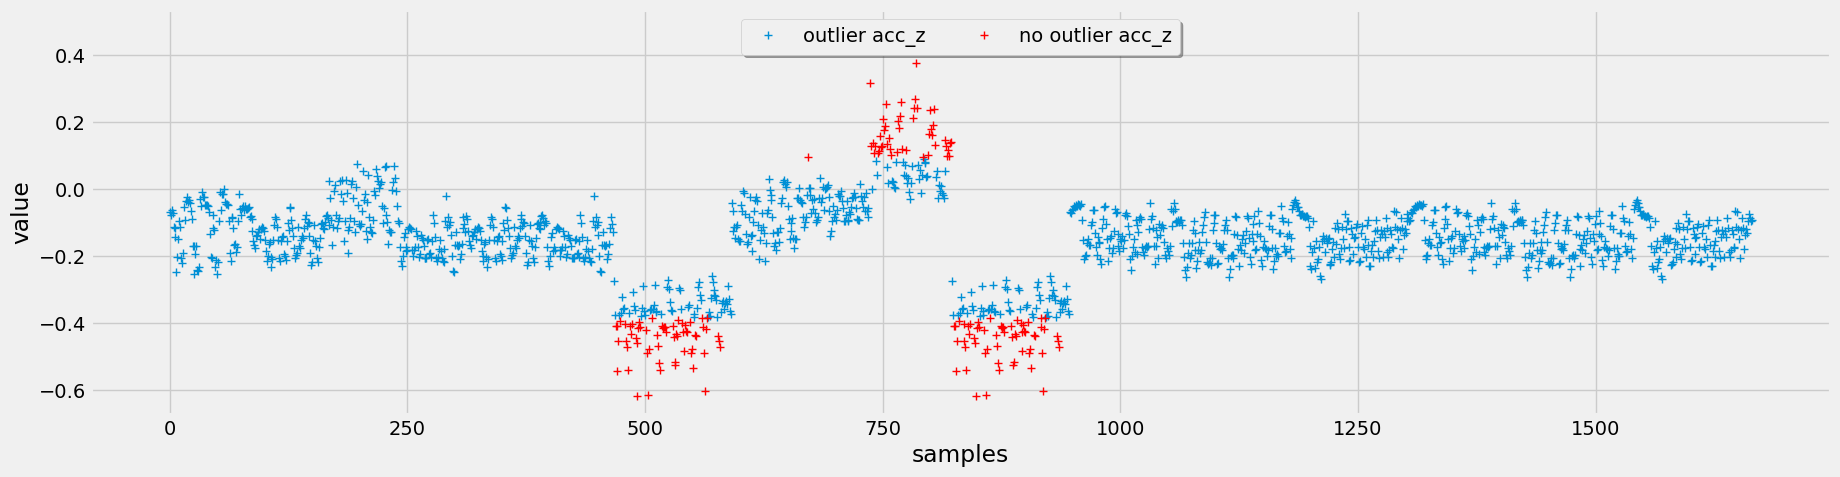

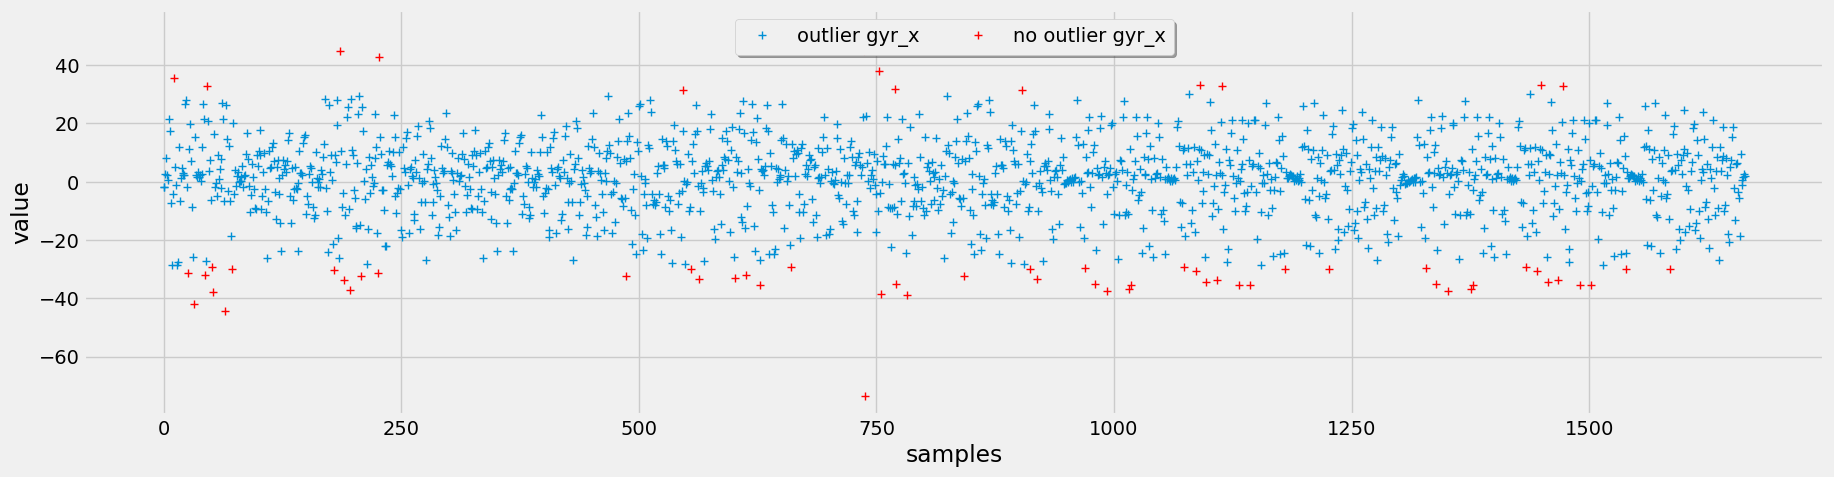

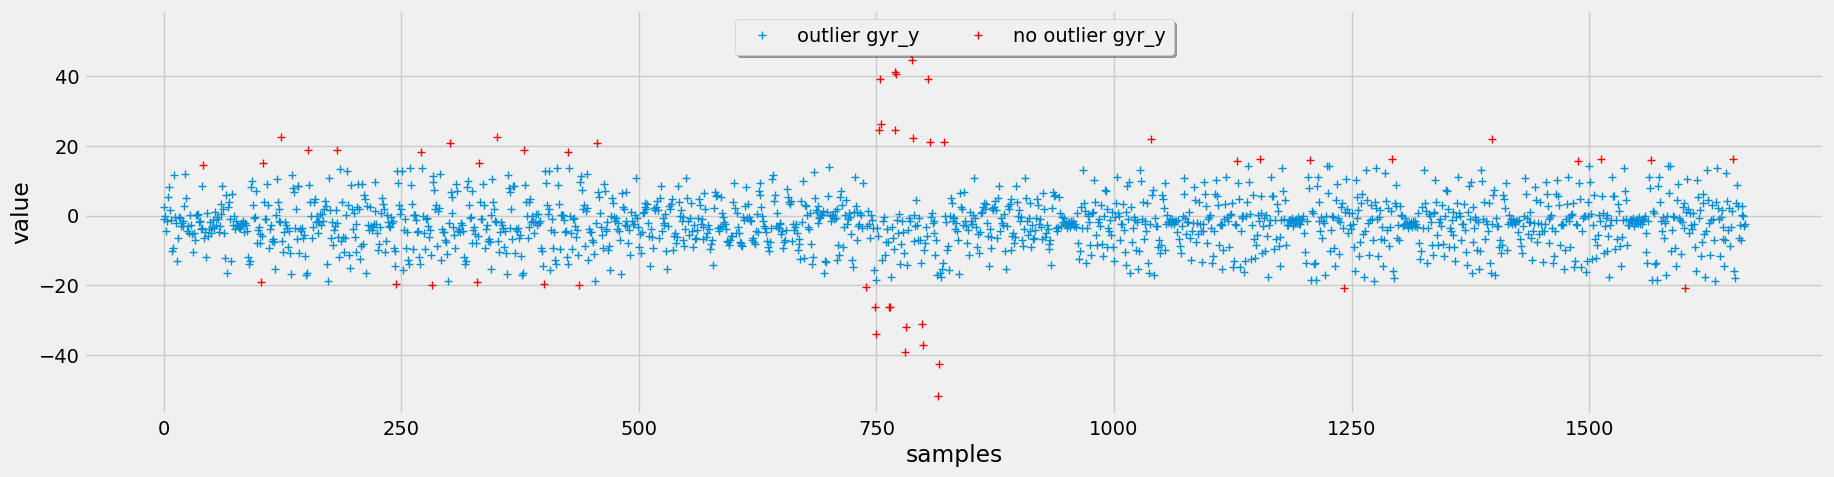

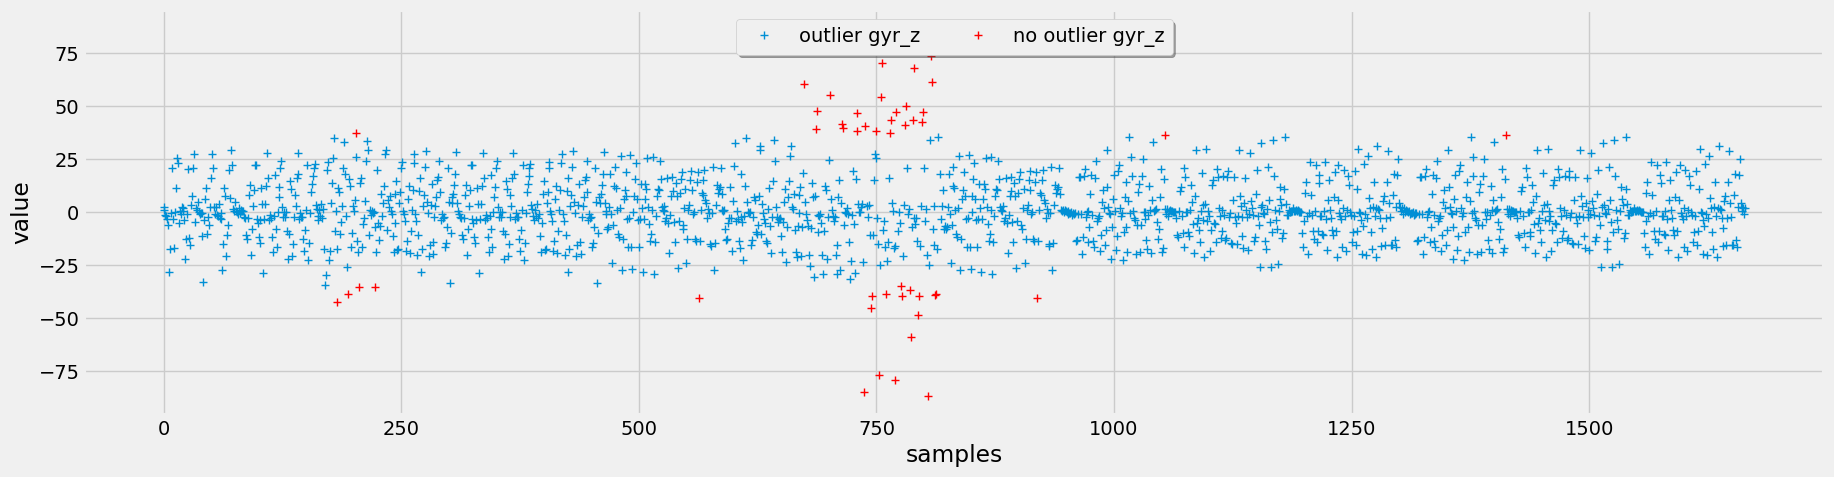

In [136]:
# --------------------------------------------------------------
# Check outliers grouped by label
# --------------------------------------------------------------
label="bench"
for col in outlier_columns:
    dataset= mark_outliers_iqr(df[df["label"]==label],col)
    plot_binary_outliers(dataset,col,col+"_outlier",reset_index=True)

In [ ]:
# --------------------------------------------------------------
# Choose method and deal with outliers
# --------------------------------------------------------------


In [ ]:
# Test on single column
# col="gyr_z"
# dataset=mark_outliers_chauvenet(df,col=col)

# dataset[dataset["gyr_z_outlier"]]
# dataset
# dataset.loc[dataset["gyr_z_outlier"],"gyr_z"]=np.nan
# # dataset
# # Create a loop

In [242]:
outliers_removed_df=df.copy()
for col in outlier_columns:
    for label in df["label"].unique():
        dataset= mark_outliers_chauvenet(df[df["label"]==label],col)
        dataset.loc[dataset[col+"_outlier"],col]=np.nan
        #update the col in original datafrma
        outliers_removed_df.loc[(outliers_removed_df["label"]==label),col]=dataset[col]
        n_outliers=len(dataset)-len(dataset[col].dropna())
        print(f"Removed{n_outliers} from {col}for  {label}")

/tmp/ipykernel_39632/1461486779.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_39632/1461486779.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_39632/1461486779.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - s

Removed0 from acc-xfor  bench
Removed2 from acc-xfor  ohp
Removed0 from acc-xfor  squat
Removed2 from acc-xfor  dead
Removed0 from acc-xfor  row
Removed0 from acc-xfor  rest


/tmp/ipykernel_39632/1461486779.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_39632/1461486779.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_39632/1461486779.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - s

Removed5 from acc-yfor  bench
Removed6 from acc-yfor  ohp
Removed0 from acc-yfor  squat
Removed0 from acc-yfor  dead
Removed0 from acc-yfor  row
Removed0 from acc-yfor  rest


/tmp/ipykernel_39632/1461486779.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_39632/1461486779.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_39632/1461486779.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - s

Removed3 from acc_zfor  bench
Removed6 from acc_zfor  ohp
Removed0 from acc_zfor  squat
Removed1 from acc_zfor  dead
Removed0 from acc_zfor  row
Removed0 from acc_zfor  rest


/tmp/ipykernel_39632/1461486779.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_39632/1461486779.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_39632/1461486779.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - s

Removed2 from gyr_xfor  bench
Removed4 from gyr_xfor  ohp
Removed1 from gyr_xfor  squat
Removed6 from gyr_xfor  dead
Removed0 from gyr_xfor  row
Removed12 from gyr_xfor  rest


/tmp/ipykernel_39632/1461486779.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_39632/1461486779.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_39632/1461486779.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - s

Removed14 from gyr_yfor  bench
Removed15 from gyr_yfor  ohp
Removed9 from gyr_yfor  squat
Removed14 from gyr_yfor  dead
Removed10 from gyr_yfor  row
Removed9 from gyr_yfor  rest


/tmp/ipykernel_39632/1461486779.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_39632/1461486779.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_39632/1461486779.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - s

Removed13 from gyr_zfor  bench
Removed1 from gyr_zfor  ohp
Removed12 from gyr_zfor  squat
Removed14 from gyr_zfor  dead
Removed0 from gyr_zfor  row
Removed24 from gyr_zfor  rest


/tmp/ipykernel_39632/1461486779.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_39632/1461486779.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


In [252]:
# Export new dataframe
# --------------------------------------------------------------
# n_outliers
outliers_removed_df.info()

outliers_removed_df.to_pickle("/home/ojas-srivastava/Desktop/data-science-template-main/data/interim/outlier_removed.pkl")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc-x        9005 non-null   float64
 1   acc-y        8998 non-null   float64
 2   acc_z        8999 non-null   float64
 3   gyr_x        8984 non-null   float64
 4   gyr_y        8938 non-null   float64
 5   gyr_z        8945 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 774.2+ KB
